# Using Siphon with NCI THREDDS Data Server

Siphon is a collection of Python utilities for downloading data from Unidata data technologies. More information on installing and using Unidata's Siphon can be found: 
https://github.com/Unidata/siphon

**The following will go through how to:** <br \>
- Use Siphon to find and query Landsat data hosted at NCI


<br>

<br/>


## Browse for data

Begin by going to NCI's Geonetwork page: http://geonetwork.nci.org.au/

This page contains the metadata records for NCI Data Collections as well as information on where to find the data. 

<img src="./images/gn1.png">

In this example, we will search for Landsat data:

<img src="./images/gn2.png">

If we click on the first result, we see a brief overview of the metadata record. **Note:** For the full record, navigate to the upper-right corner of your browser to change to the "Full view" (eyeball icon). 

One of the options under **Download and links** is the NCI THREDDS Data Server Catalog page: 

<img src="./images/gn3.png">

By navigating to this link, the available (public) data subcollections and datasets will be visible:

<img src="./images/thredds10.png">


In this example, let's navigate to the ** LANDSAT data: scenes and tiles/ tiles/ EPSG3577/ LS8_OLI_TIRS_NBAR/ ** dataset: 

<img src="./images/thredds11.png">

## Using Siphon

Once selecting a parent dataset directory, Siphon can be used to search and use the data access methods and services provided by THREDDS. For example, Siphon will return a list of data endpoints for the OPeNDAP data URL, NetCDF Subset Service (NCSS), Web Map Service (WMS), Web Coverage Service (WCS), and the HTTP link for direct download. 

### Import python packages

In [3]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
from siphon import catalog, ncss
%matplotlib inline

### Provide the top-level URL from the THREDDS page above
Note: You can leave the '.html' but you will receive a message saying it was changed to '.xml'. 

<img src="./images/thredds13.png">

In [6]:
catalog_url = 'http://dapds00.nci.org.au/thredds/catalog/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/catalog.xml'

### Now we use Siphon to list all the available datasets under this catalog

In [8]:
tds = catalog.TDSCatalog(catalog_url)
datasets = list(tds.datasets)
endpts = tds.datasets.values()

#### Some of the datasets...

In [9]:
datasets[:10]

['LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-11_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-12_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-13_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-14_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-15_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-16_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-17_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-18_2013.nc',
 'LS8_OLI_TIRS_NBAR_3577_-10_-19_2013.nc']

#### And their associated endpoints for data services:

In [5]:
endpts[0].access_urls

{'HTTPServer': 'http://dapds00.nci.org.au/thredds/fileServer/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'ISO': 'http://dapds00.nci.org.au/thredds/iso/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'NCML': 'http://dapds00.nci.org.au/thredds/ncml/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'NetcdfSubset': 'http://dapds00.nci.org.au/thredds/ncss/grid/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'OPENDAP': 'http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'UDDC': 'http://dapds00.nci.org.au/thredds/uddc/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'WCS': 'http://dapds00.nci.org.au/thredds/wcs/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_-10_-10_2013.nc',
 'WMS': 'http://dapds00.nci.org.au/thredds/wms/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS

### Now we can use Siphon along with some form of query method to find some data

#### This example will use Shapely to find intersecting Polygon shapes

In [11]:
from shapely.geometry import Polygon
from shapely.wkt import loads

query = (136, 138, -29.3, -27.8)
query = Polygon([[136, -29.3], [136, -27.8], [138, -27.8], [138, -29.3]])

# What this query looks like in WKT
print query.wkt

POLYGON ((136 -29.3, 136 -27.8, 138 -27.8, 138 -29.3, 136 -29.3))


#### Loop through the datasets and check if the Landsat's geospatial bounds (which is in a WKT polygon format) intersects with the query

In [8]:
%%time 

matches = []
for dataset in endpts:
    dap = dataset.access_urls['OPENDAP']
    with Dataset(dap) as f:
        bounds = loads(f.geospatial_bounds.encode())
        if bounds.intersects(query) == True:
            print dap
            matches.append(dap)

http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_3_-31_2013.nc
http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_3_-32_2013.nc
http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_4_-31_2013.nc
http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_4_-32_2013.nc
http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_5_-31_2013.nc
http://dapds00.nci.org.au/thredds/dodsC/rs0/tiles/EPSG3577/LS8_OLI_TIRS_NBAR/LS8_OLI_TIRS_NBAR_3577_5_-32_2013.nc
CPU times: user 5.27 s, sys: 2.19 s, total: 7.45 s
Wall time: 32.2 s


### Let's take a quick look at what was found 

(Because we are accessing data remotely through OPeNDAP, let's look at a lower resolution so it doesn't exceed memory limits.)

/Users/kdruken/anaconda/envs/python2/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


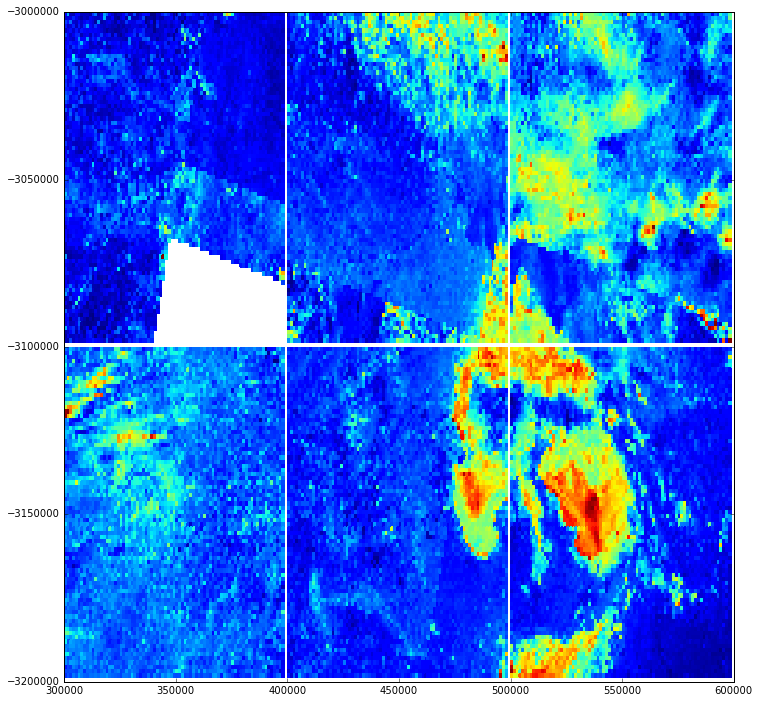

In [9]:
plt.figure(figsize=(12,12))

for match in matches:
    with Dataset(match) as f:
        x = f.variables['x'][::50]
        y = f.variables['y'][::50]
        t = f.variables['time'][::5]
        
        for i in range(0, len(t)):
            b2 = f.variables['band_2'][i,::50,::50]
            plt.pcolormesh(x, y, b2)